In [1]:
import os
import json
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats

from tqdm import tqdm
from pprint import pprint

import seaborn as sns
sns.set_style("darkgrid")

from collections import Counter, OrderedDict, defaultdict

from data_processing import is_english

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davitmartirosyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Reading data:

In [2]:
files = sorted(glob.glob('data/*.json'))

data = []

for i, file in enumerate(files):
    with open(file, 'r') as f:
        json_file = json.load(f)
        print('Sample{index} contains {n} queries'.format(index=i+1,n=len(json_file)))
        data.append(json_file)

Sample1 contains 9275 queries
Sample2 contains 40468 queries
Sample3 contains 7537 queries
Sample4 contains 16887 queries
Sample5 contains 36601 queries
Sample6 contains 762 queries
Sample7 contains 11360 queries
Sample8 contains 9 queries


Sample8 has only 9 queries, so we drop it.

In [3]:
del data[-1]
assert len(data)==7

In [4]:
# json -> pd.Dataframe
for i, sample in enumerate(data):
    df = pd.DataFrame(columns=['time_stamp','query'])
    df['time_stamp'] = [e['time'] for e in sample]
    df['time_stamp'] = pd.to_datetime(df['time_stamp'])
    df['year'] = df['time_stamp'].apply(lambda x: x.year)
    df['date'] = df['time_stamp'].dt.date
    df['query'] = [e['title'][13:] for e in sample]
    
    print('Sample{}:'.format(i+1))
    print(df.head(3),'\n')
    
    data[i] = df

Sample1:
                        time_stamp                           query  year  \
0 2020-10-28 12:30:18.060000+00:00   does python read line by line  2020   
1 2020-10-28 12:08:44.380000+00:00           real time vs cpu time  2020   
2 2020-10-28 12:05:30.968000+00:00  does python read top to bottom  2020   

         date  
0  2020-10-28  
1  2020-10-28  
2  2020-10-28   

Sample2:
                        time_stamp                       query  year  \
0 2020-11-06 14:46:25.559000+00:00         bash append to file  2020   
1 2020-11-06 14:42:38.618000+00:00               bash for loop  2020   
2 2020-11-06 14:33:23.067000+00:00  jupyter notebook bash cell  2020   

         date  
0  2020-11-06  
1  2020-11-06  
2  2020-11-06   

Sample3:
                        time_stamp                                 query  \
0 2019-06-29 11:43:55.066000+00:00                      бутыль воды 19 л   
1 2019-06-29 07:02:30.796000+00:00                           pdf to word   
2 2019-06-29 06:59:

In [5]:
for i, sample in enumerate(data):
    count = 0
    for q in sample['query']:
        if is_english(q):
            count+=1
    
    share = np.round(100 * count/len(sample['query']),2)
    print('Share of English queries in Sample{index} = {p}%'.format(index=i+1,p=share))

Share of English queries in Sample1 = 99.3%
Share of English queries in Sample2 = 97.33%
Share of English queries in Sample3 = 58.56%
Share of English queries in Sample4 = 93.37%
Share of English queries in Sample5 = 96.56%
Share of English queries in Sample6 = 99.61%
Share of English queries in Sample7 = 58.04%


Vizualizing the number of searches per year for each of the samples:

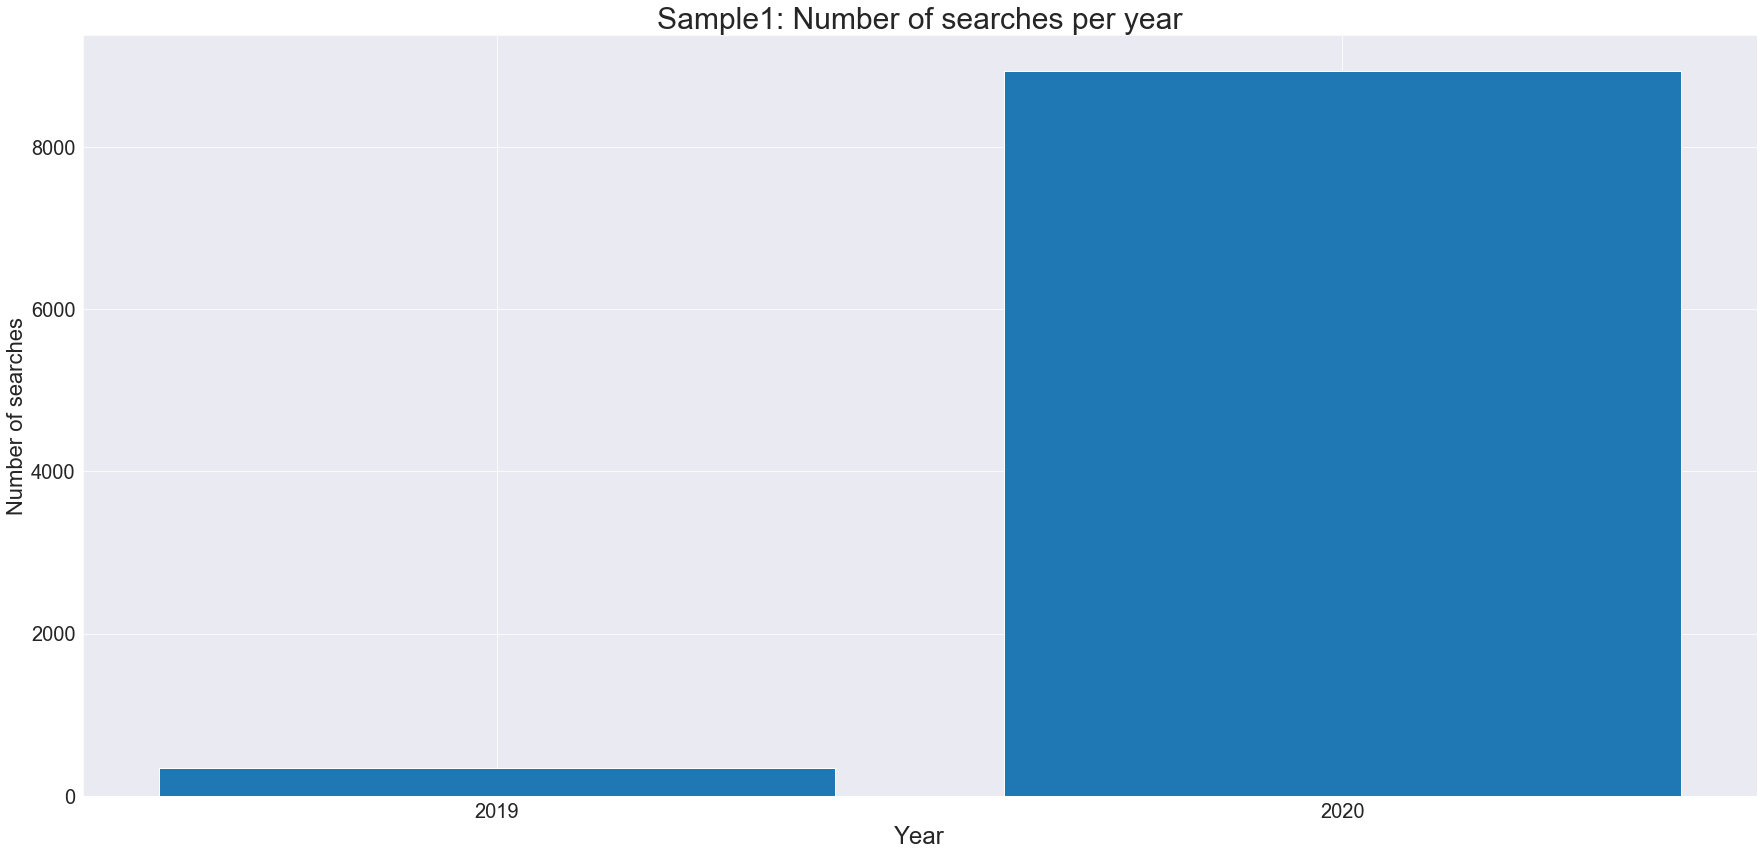

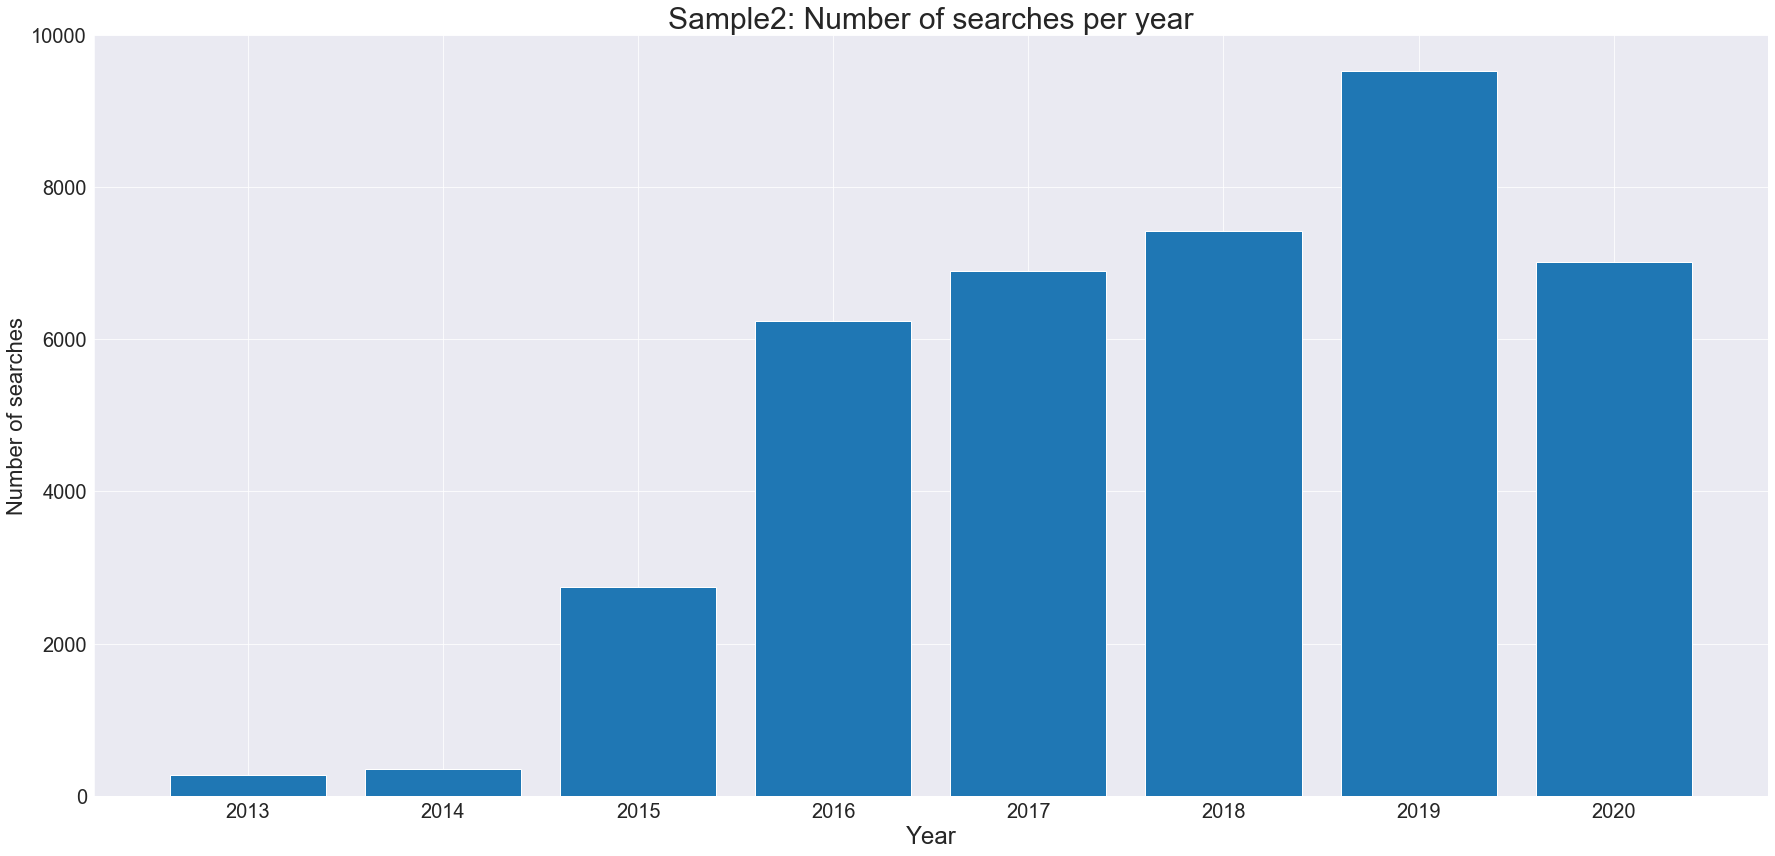

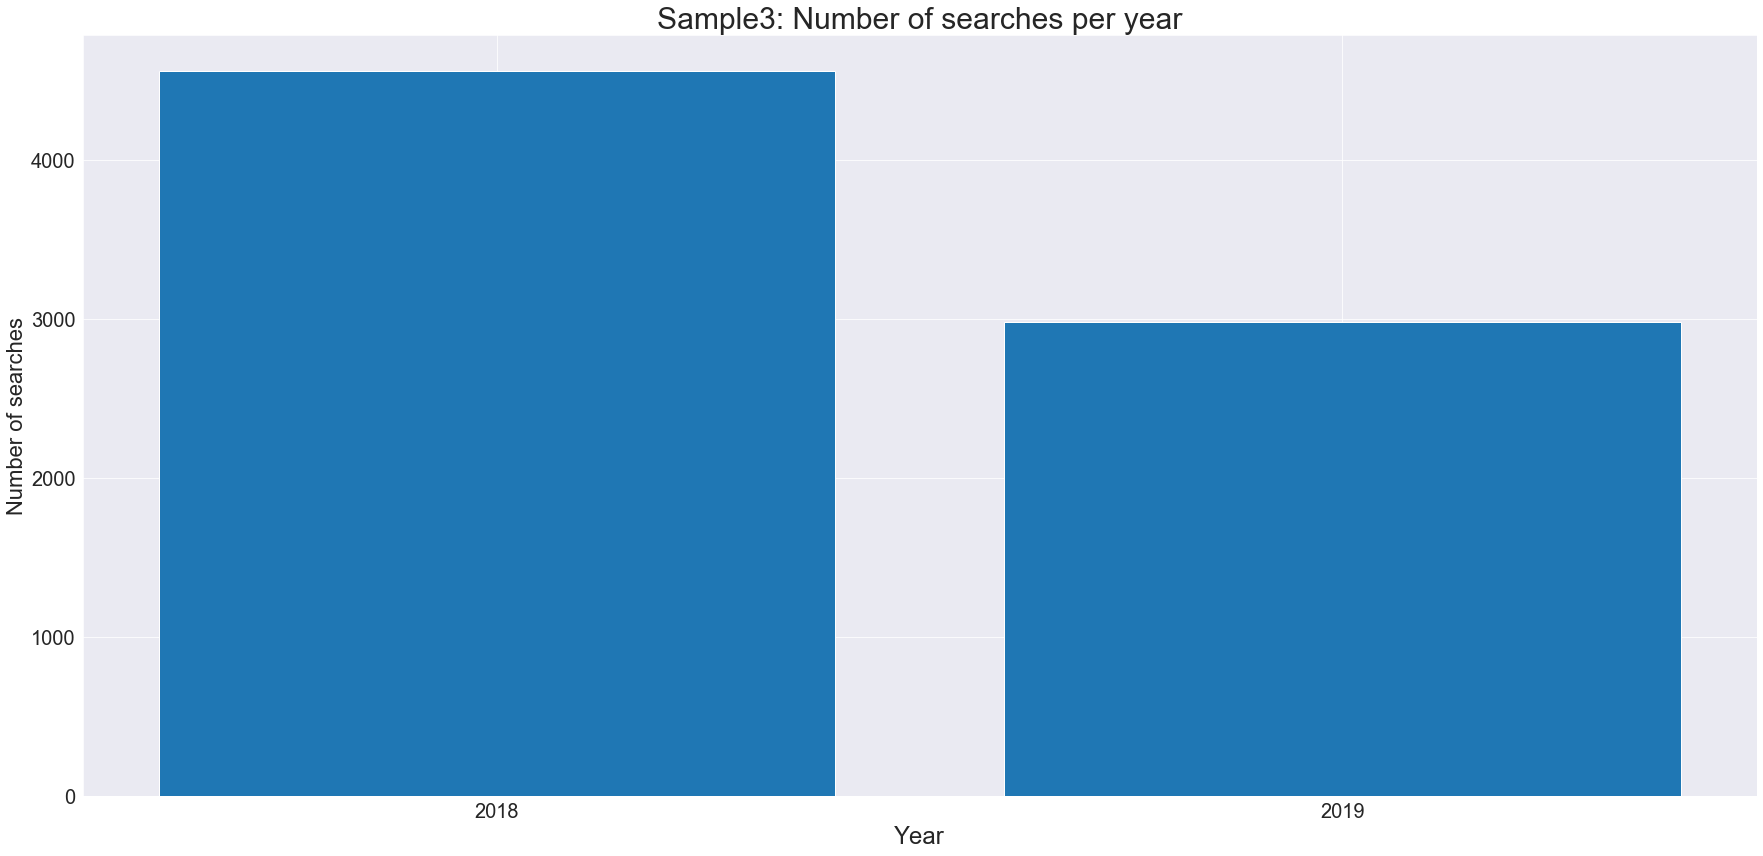

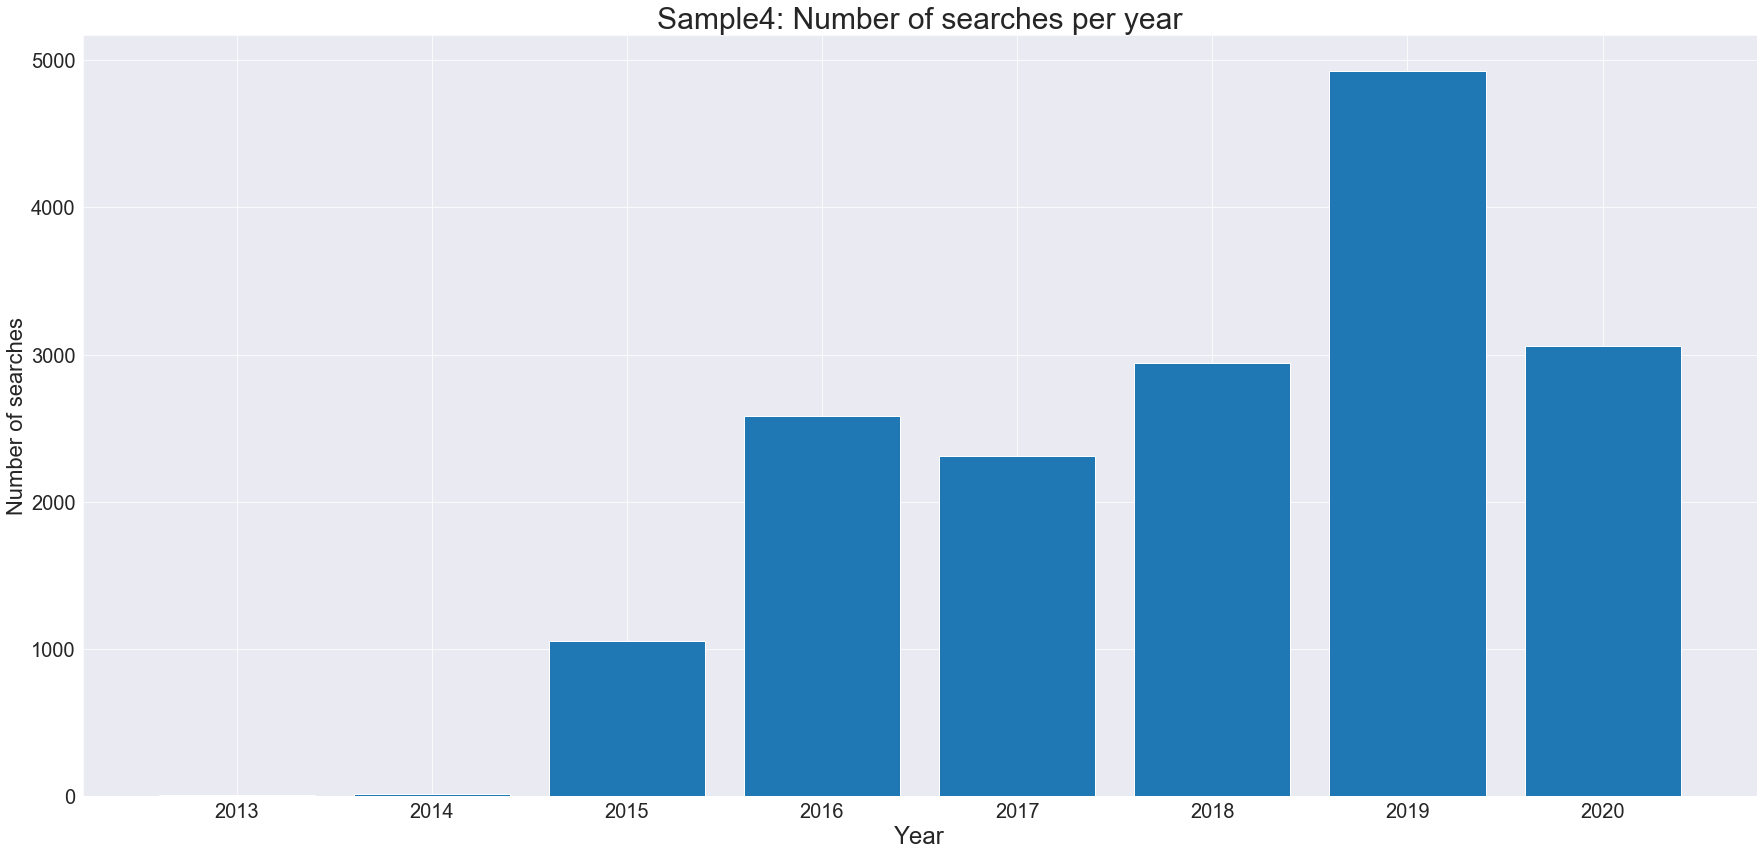

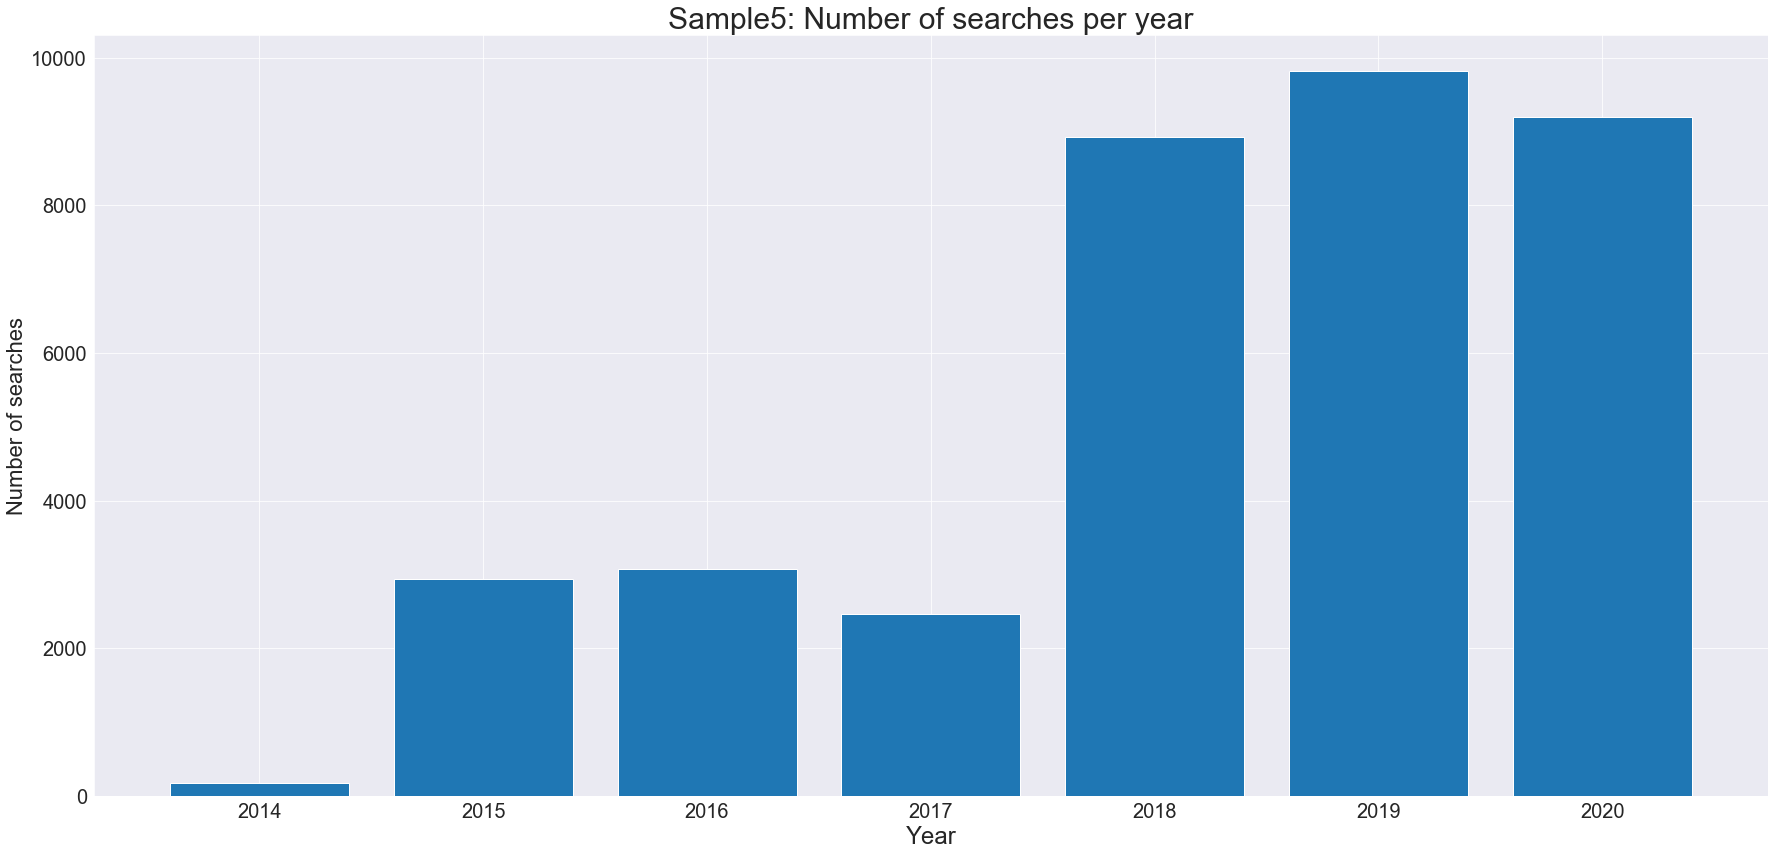

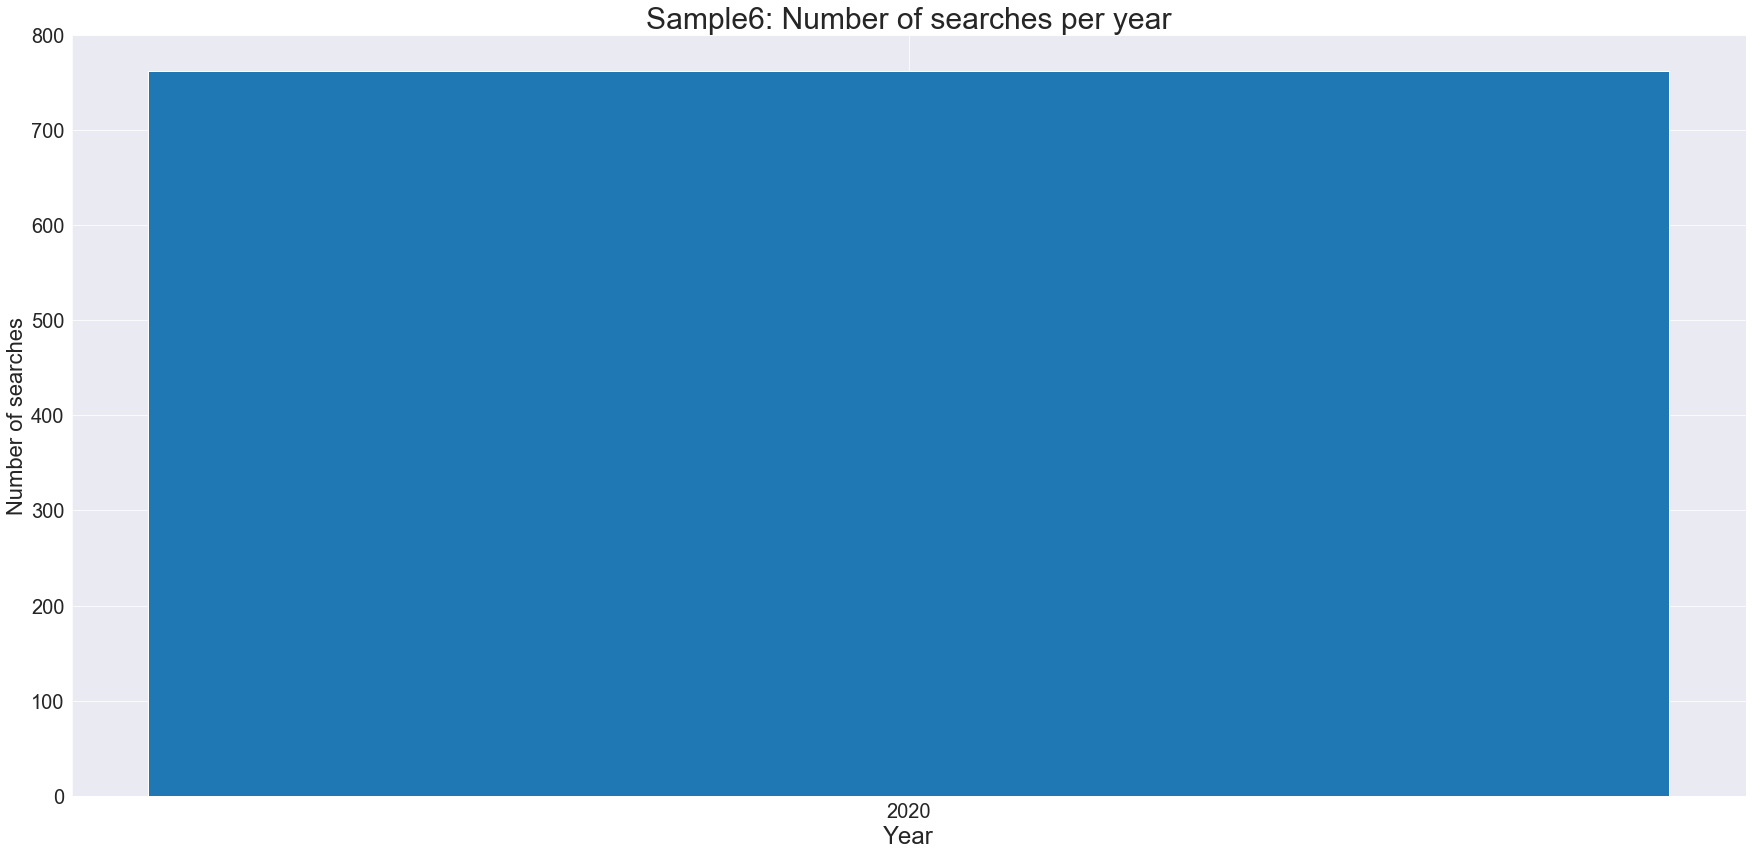

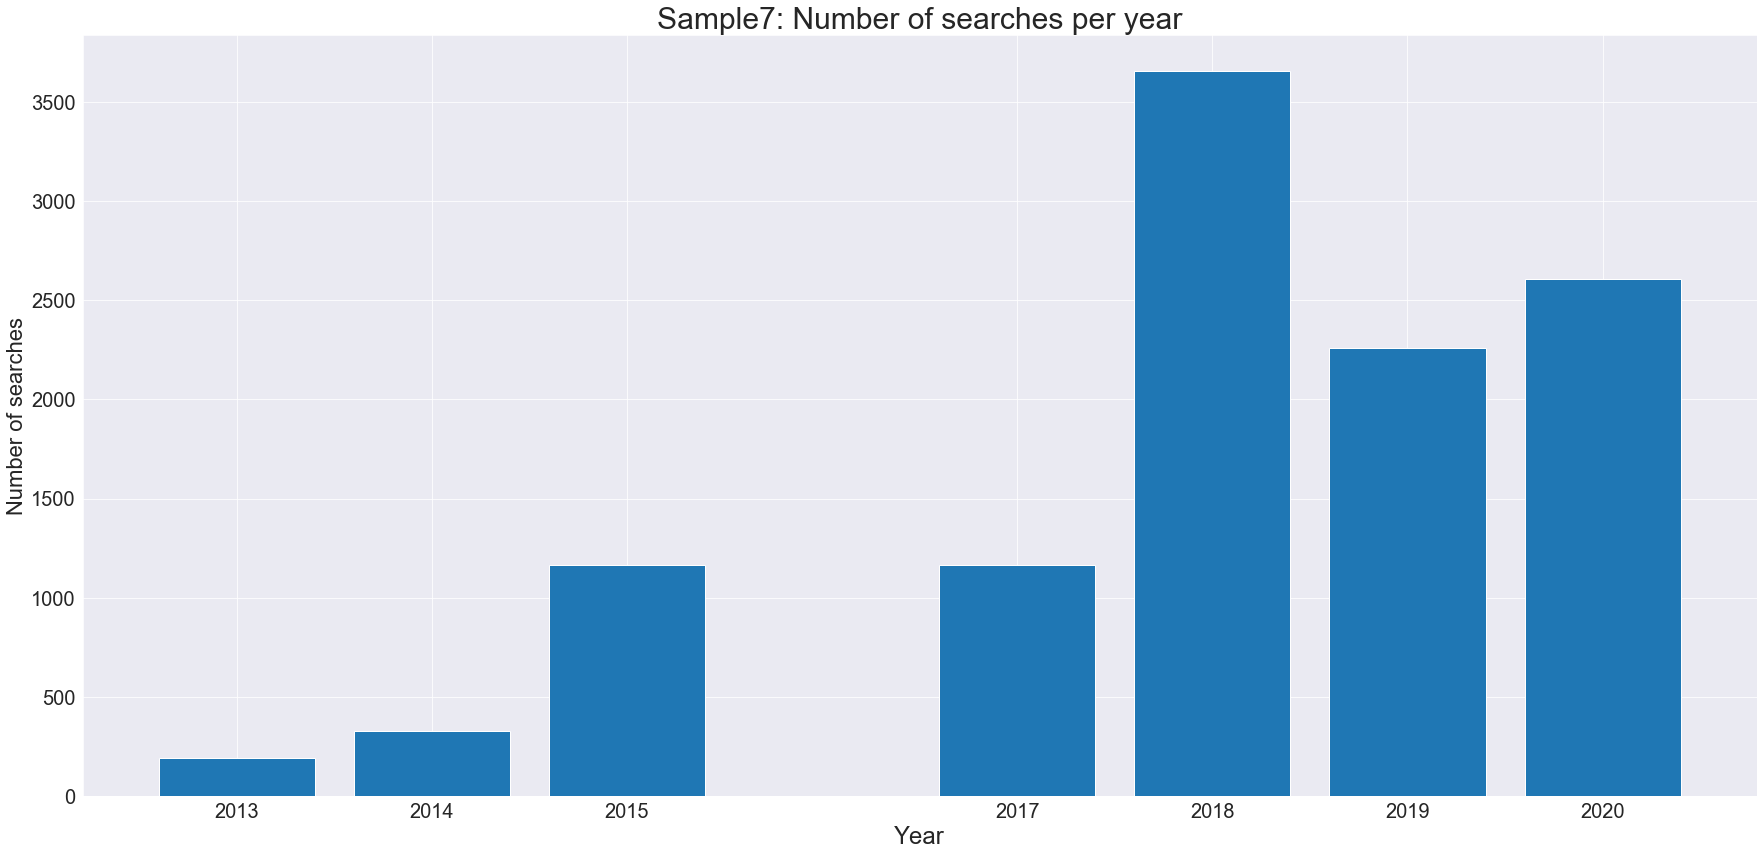

In [6]:
for i, sample in enumerate(data):
    distr = sample['year'].value_counts().sort_index()
    plt.figure(figsize=(30,14))
    plt.bar(distr.index,distr.values)
    plt.title('Sample{}: Number of searches per year'.format(i+1),fontsize=30)
    plt.xlabel('Year',fontsize=24)
    plt.ylabel('Number of searches',fontsize=22)
    plt.xticks(distr.index,distr.index,fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

----------------------------------------------------------------------------------------------------------------

### Data processing

Let's now do some data processing to understand the data better and obtain more interesting and informative vizualizations.

In [7]:
from data_processing import tokenize, remove_stopwords, lemmatization

In [8]:
processed_data = []

for i, sample in enumerate(data):
    queries = sample['query'].apply(lambda q: q if is_english(q) else '').tolist() # keep only English queries
    queries_tok = tokenize(queries)
    queries_cln = remove_stopwords(queries_tok)
    
    print('Sample{}'.format(i+1))
    print('-----------------')
    pprint(queries_cln[:5])
    print('\n')
    
    processed_data.append(queries_cln)

Sample1
-----------------
[['python', 'read', 'line', 'line'],
 ['real', 'time', 'cpu', 'time'],
 ['python', 'read', 'top', 'bottom'],
 ['sas', 'excel'],
 ['sas', 'dollar', 'sign', 'format']]


Sample2
-----------------
[['bash', 'append', 'file'],
 ['bash', 'loop'],
 ['jupyter', 'notebook', 'bash', 'cell'],
 ['nc', 'multiple', 'inputs', 'command', 'line'],
 ['python', 'netcat']]


Sample3
-----------------
[[], ['pdf', 'word'], [], [], []]


Sample4
-----------------
[['salty', 'water', 'dehydrates'],
 ['gith'],
 ['error',
  'invalid',
  'value',
  'parameter',
  'overrides',
  'access_token',
  'eaaaegrdyevo',
  'vslvwi',
  'rts',
  'juhotywwwt',
  'cjh',
  'eiw',
  'dhwow',
  'xt',
  'mi',
  'dkra',
  'valid',
  'format'],
 ['access_token',
  'eaaaegrdyevo',
  'vslvwi',
  'rts',
  'juhotywwwt',
  'cjh',
  'eiw',
  'dhwow',
  'xt',
  'mi',
  'dkra',
  'valid',
  'format'],
 ['pandok', 'yerevan']]


Sample5
-----------------
[['tiziano', 'piccardi'],
 ['epfl'],
 ['west', 'robert'],
 [

In [9]:
for i, sample in enumerate(processed_data):
    
    print('Sample{}'.format(i+1))
    print('-----------------')
    
    words = [word for doc in sample for word in doc]
    
    print('Total number of (English) words in all queries taken together = {}'.format(len(words)))
    print('Total number of (English) unique words = {}\n'.format(len(set(words))))

Sample1
-----------------
Total number of (English) words in all queries taken together = 26474
Total number of (English) unique words = 4306

Sample2
-----------------
Total number of (English) words in all queries taken together = 118911
Total number of (English) unique words = 14273

Sample3
-----------------
Total number of (English) words in all queries taken together = 11383
Total number of (English) unique words = 3051

Sample4
-----------------
Total number of (English) words in all queries taken together = 49979
Total number of (English) unique words = 10500

Sample5
-----------------
Total number of (English) words in all queries taken together = 97380
Total number of (English) unique words = 13345

Sample6
-----------------
Total number of (English) words in all queries taken together = 1540
Total number of (English) unique words = 710

Sample7
-----------------
Total number of (English) words in all queries taken together = 12998
Total number of (English) unique words = 432

Please note that "(English) words" refers to those words that are composed of only English alphabet characters. However, they do not necessarily need to have meaning in English. 

From now on, always assume that we are working only with such words, phrases, etc. unless said otherwise. Therefore, we will no longer say "(English) words", "(English) phrases", etc. but simply "words", "phrases", etc.

Let's visualize the distribution of word frequences for each of our samples.

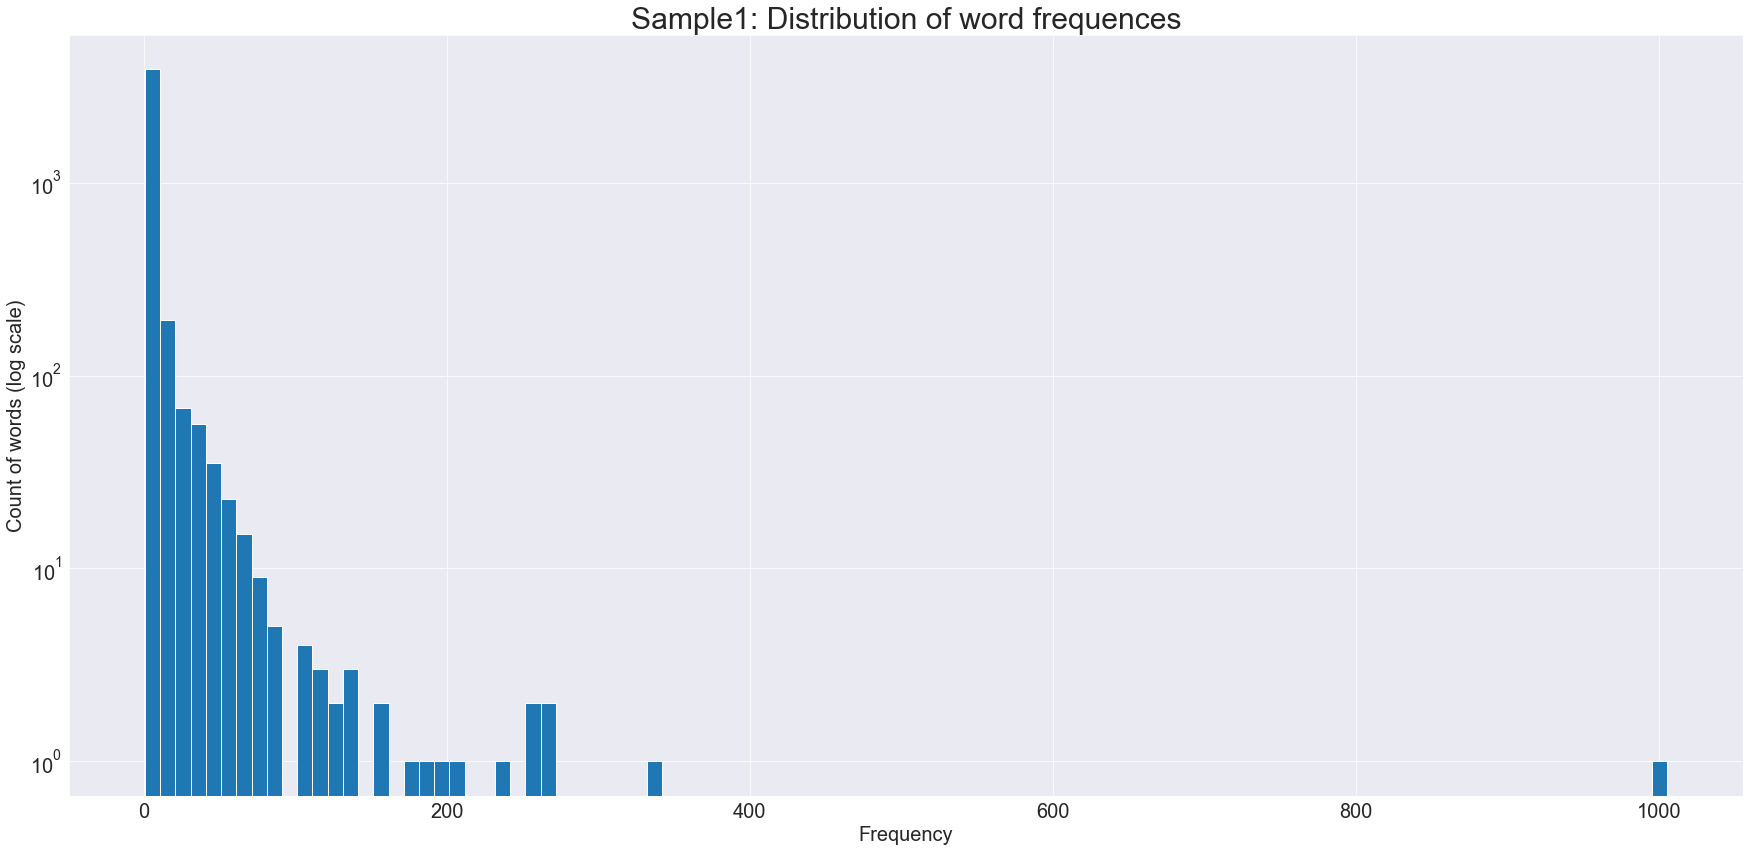

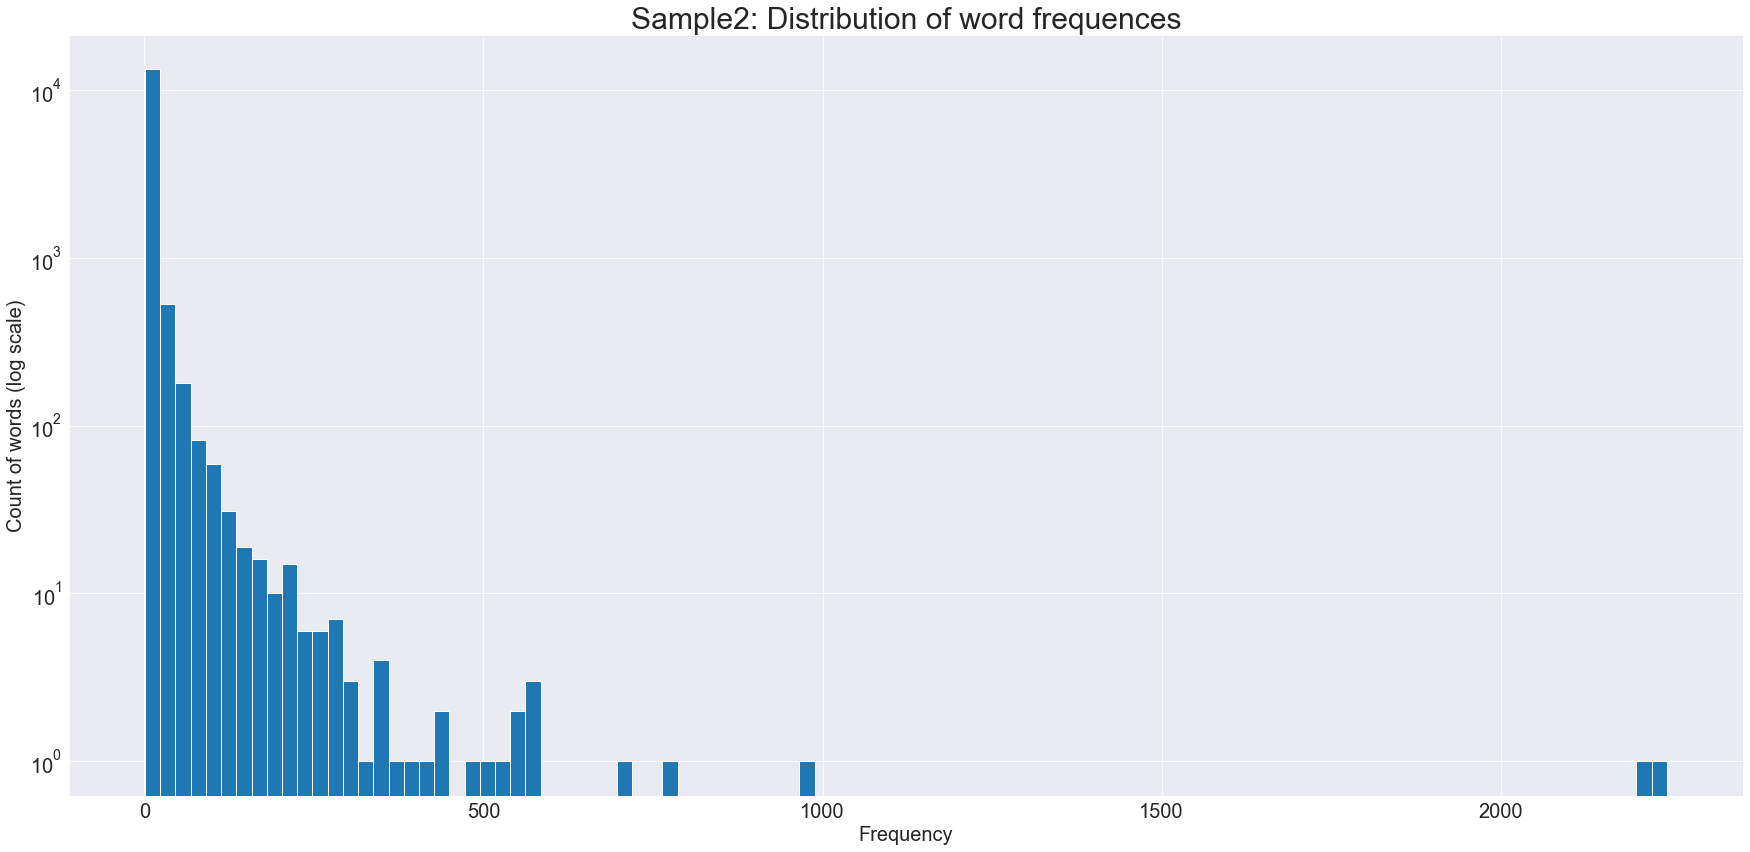

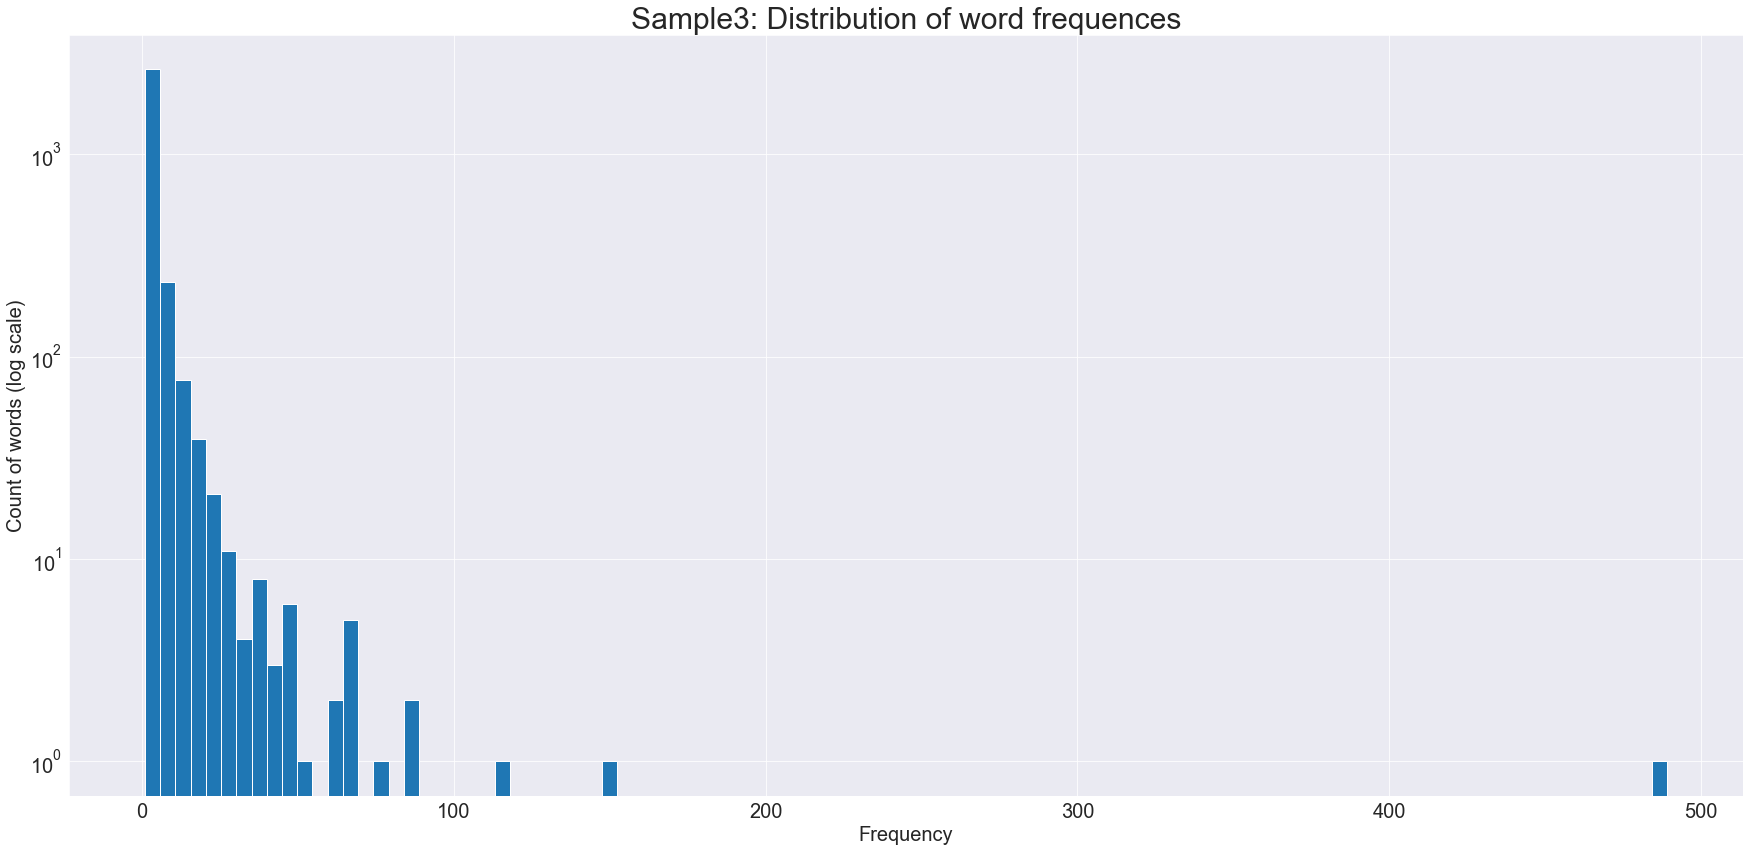

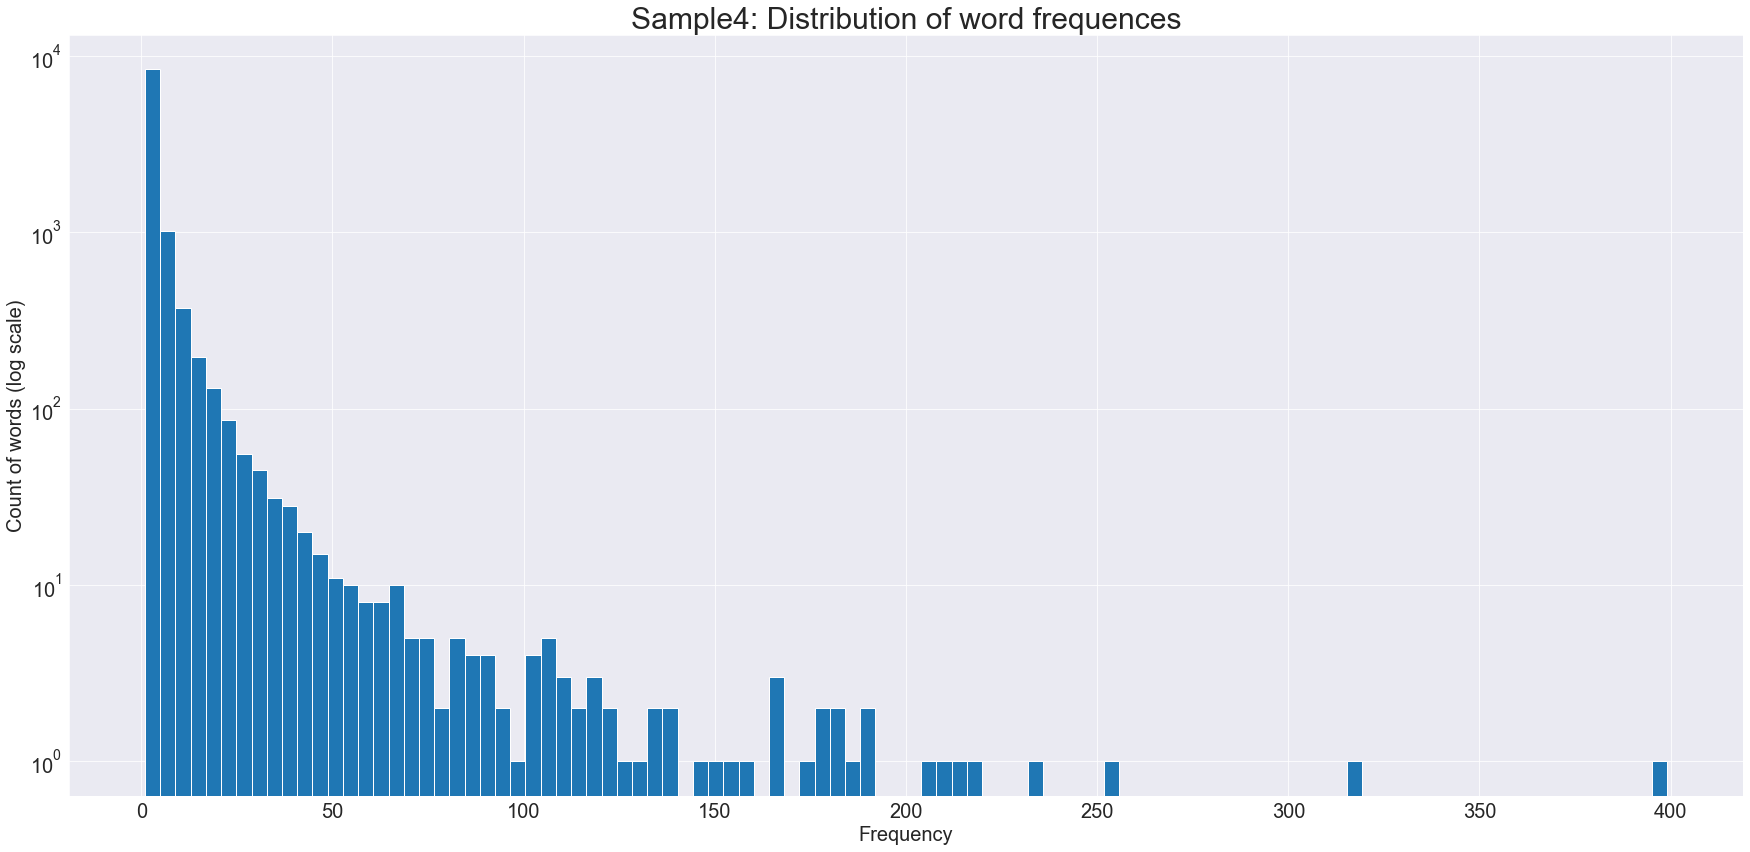

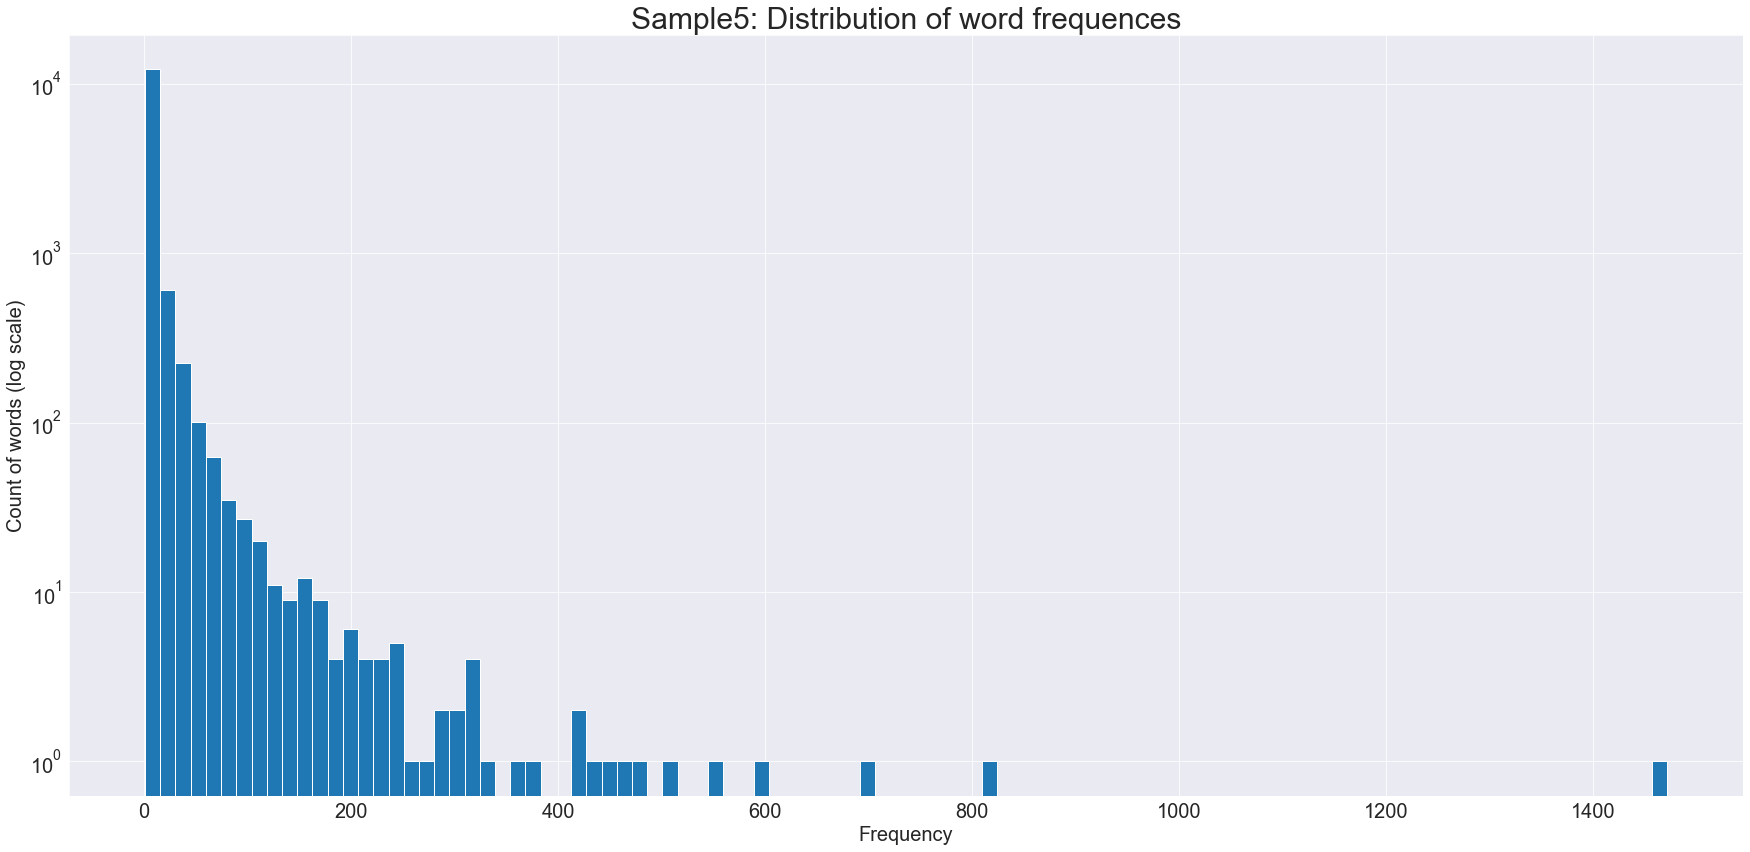

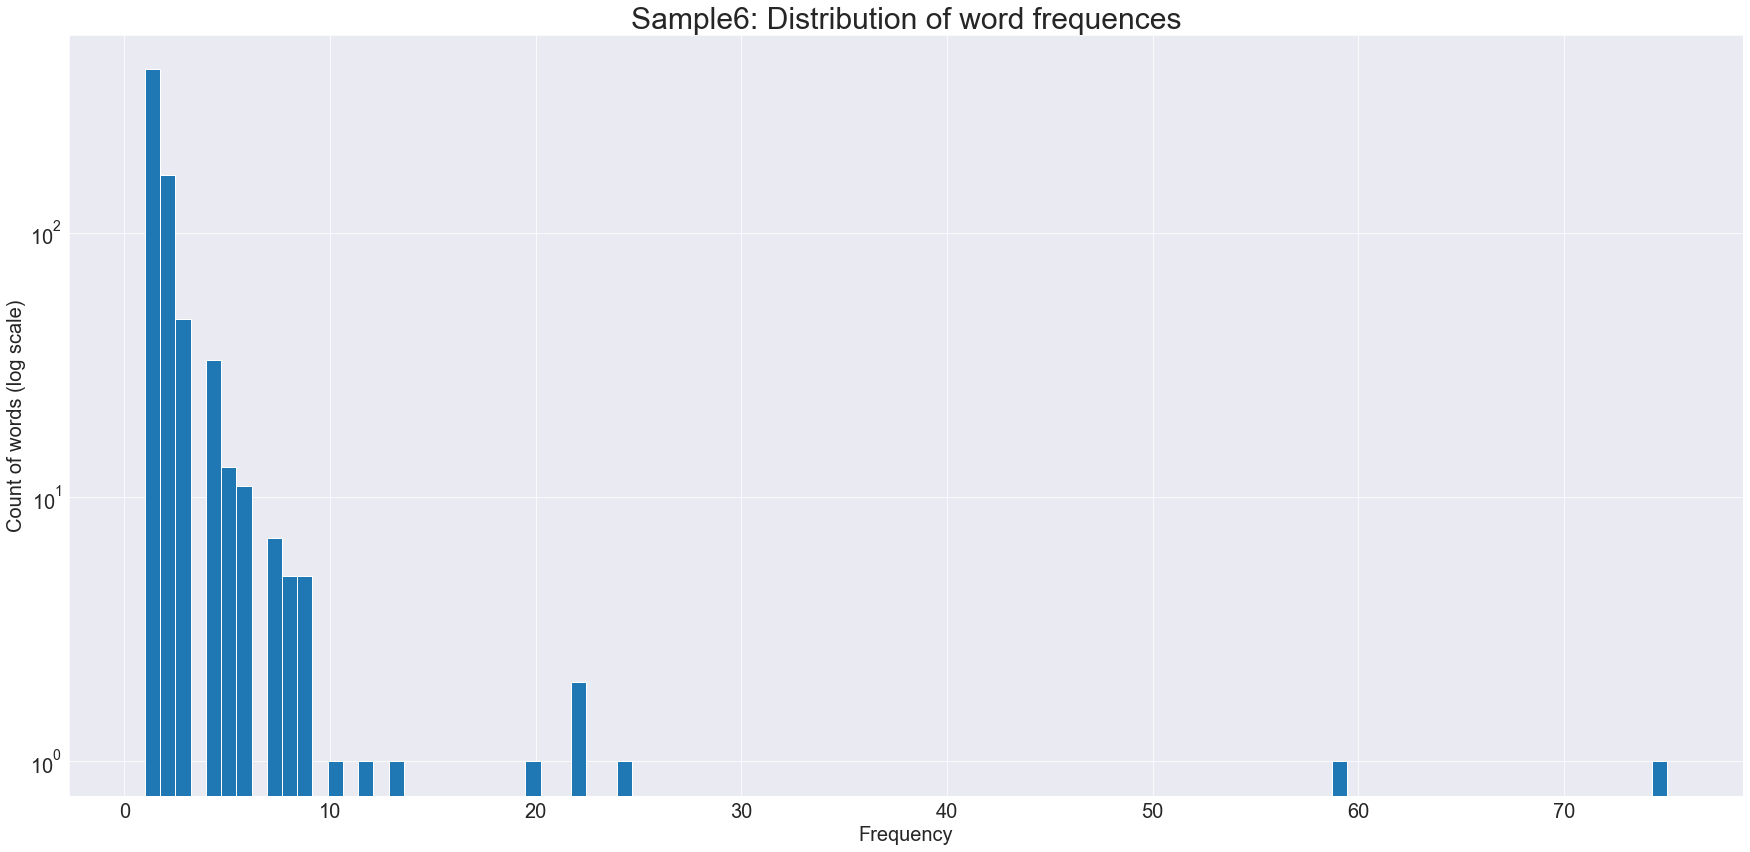

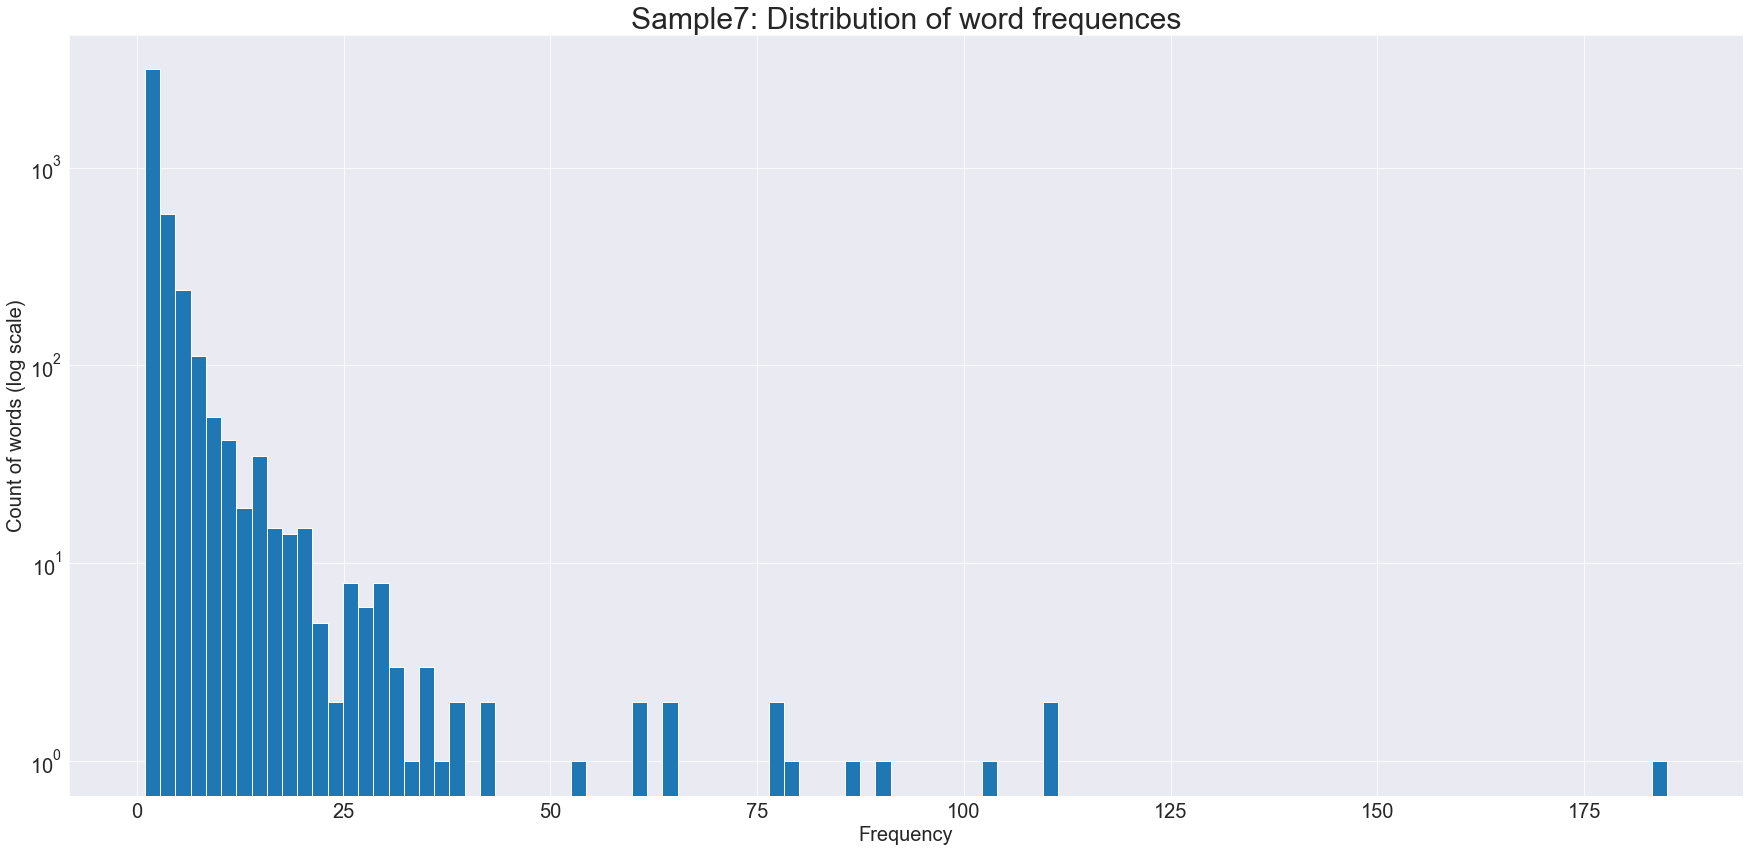

In [10]:
for i, sample in enumerate(processed_data):
    
    words = [word for doc in sample for word in doc]

    count = Counter(words)
    count_srt = {k: v for k, v in sorted(count.items(), key=lambda item: -item[1])}

    plt.figure(figsize=(30,14))
    plt.hist(count_srt.values(),bins=100)
    plt.title('Sample{}: Distribution of word frequences'.format(i+1),fontsize=30)
    plt.xlabel('Frequency',fontsize=20)
    plt.ylabel('Count of words (log scale)',fontsize=20)
    plt.yscale('log')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

In [11]:
for i, sample in enumerate(processed_data):
    
    words = [word for doc in sample for word in doc]

    count = Counter(words)
    count_srt = {k: v for k, v in sorted(count.items(), key=lambda item: -item[1])}
    
    print('Sample{}: All time top-10 most frequent words'.format(i+1))
    for j, w in enumerate(count_srt.keys()):
        print('{index}. {w}'.format(index=j+1,w=w))
        if j>=9:
            print()
            break

Sample1: All time top-10 most frequent words
1. python
2. learning
3. haskell
4. pytorch
5. object
6. latex
7. image
8. detection
9. numpy
10. yolov

Sample2: All time top-10 most frequent words
1. python
2. android
3. keras
4. google
5. java
6. image
7. js
8. react
9. install
10. file

Sample3: All time top-10 most frequent words
1. python
2. android
3. django
4. list
5. image
6. matlab
7. matrix
8. java
9. tensorflow
10. file

Sample4: All time top-10 most frequent words
1. java
2. google
3. armenia
4. mac
5. sql
6. aws
7. online
8. file
9. download
10. history

Sample5: All time top-10 most frequent words
1. python
2. man
3. utd
4. league
5. android
6. epfl
7. google
8. mac
9. data
10. online

Sample6: All time top-10 most frequent words
1. wshh
2. app
3. social
4. store
5. grimedaily
6. arsenal
7. league
8. film
9. screenshot
10. tv

Sample7: All time top-10 most frequent words
1. translate
2. yerevan
3. armenia
4. design
5. ui
6. google
7. size
8. iphone
9. class
10. mercedes



Obviously, there are words that very frequently occur together (e.g. 'man' and 'utd') and only if considered together convey the right meaning. Therefore, it is logical to build at least bigrams.

In [12]:
from data_processing import add_bigrams

In [13]:
processed_data_bigrams = []

for each in processed_data:
    processed_data_bigrams.append(add_bigrams(each))

In [14]:
for i, sample in enumerate(processed_data_bigrams):
    
    words = [word for doc in sample for word in doc]

    count = Counter(words)
    count_srt = {k: v for k, v in sorted(count.items(), key=lambda item: -item[1])}
    
    print('Sample{}: All time top-10 most frequent words/phrases'.format(i+1))
    for j, w in enumerate(count_srt.keys()):
        print('{index}. {w}'.format(index=j+1,w=w))
        if j>=9:
            print()
            break

Sample1: All time top-10 most frequent words/phrases
1. python
2. haskell
3. pytorch
4. latex
5. image
6. list
7. object_detection
8. numpy
9. java
10. file

Sample2: All time top-10 most frequent words/phrases
1. python
2. android
3. keras
4. java
5. file
6. image
7. tensorflow
8. string
9. github
10. firebase

Sample3: All time top-10 most frequent words/phrases
1. python
2. android
3. django
4. list
5. matlab
6. image
7. matrix
8. tensorflow
9. numpy
10. file

Sample4: All time top-10 most frequent words/phrases
1. java
2. armenia
3. mac
4. file
5. check
6. python
7. aws
8. example
9. error
10. sql

Sample5: All time top-10 most frequent words/phrases
1. python
2. man_utd
3. android
4. epfl
5. mac
6. premier_league
7. matlab
8. music
9. latex
10. function

Sample6: All time top-10 most frequent words/phrases
1. wshh
2. app
3. social
4. grimedaily
5. arsenal
6. app_store
7. film
8. screenshot
9. tv
10. industry

Sample7: All time top-10 most frequent words/phrases
1. translate
2. yer

------------------------------------------------------------------------------------------------------------

In [15]:
from utils import get_year_quarters, get_human_readable_quarter_name

In [16]:
sample4 = processed_data_bigrams[4]

In [17]:
top_words = defaultdict(list)
years = sorted(data[4].year.unique())
years

[2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [18]:
for y in years:
    qrt = get_year_quarters(y)
    
    for i in range(0,4):
        key = qrt[i][0].strftime('%d-%m-%Y')
        indices = sorted(data[4][(qrt[i][0]<=data[4].date) & (data[4].date<qrt[i][1])].index)
        
        words = [w for e in indices for w in sample4[e]]
        
        if len(words)>0:
            c = Counter(words)
            c_sort = {k: v for k, v in sorted(c.items(), key=lambda item: -item[1])}
            top_words[key] = list(c_sort.items())[:3]  

In [19]:
top_words

defaultdict(list,
            {'01-04-2014': [('asch', 2), ('impression', 2), ('formation', 2)],
             '01-07-2014': [('formation', 2),
              ('solomon_asch', 2),
              ('impression', 1)],
             '01-10-2014': [('download', 5), ('university', 5), ('define', 5)],
             '01-01-2015': [('google_translate', 17),
              ('respiration', 11),
              ('english', 8)],
             '01-04-2015': [('google_translate', 18),
              ('paper', 13),
              ('table', 10)],
             '01-07-2015': [('man_utd', 51),
              ('smotret_online', 22),
              ('movie', 22)],
             '01-10-2015': [('prove', 36),
              ('man_utd', 35),
              ('google_translate', 20)],
             '01-01-2016': [('man_utd', 43),
              ('sentence', 27),
              ('premier_league', 27)],
             '01-04-2016': [('sentence', 28), ('man_utd', 24), ('define', 22)],
             '01-07-2016': [('mac', 50), ('java', 4

In [20]:
xaxis = list(top_words.keys())
xaxis_ticks = [get_human_readable_quarter_name(e) for e in xaxis]

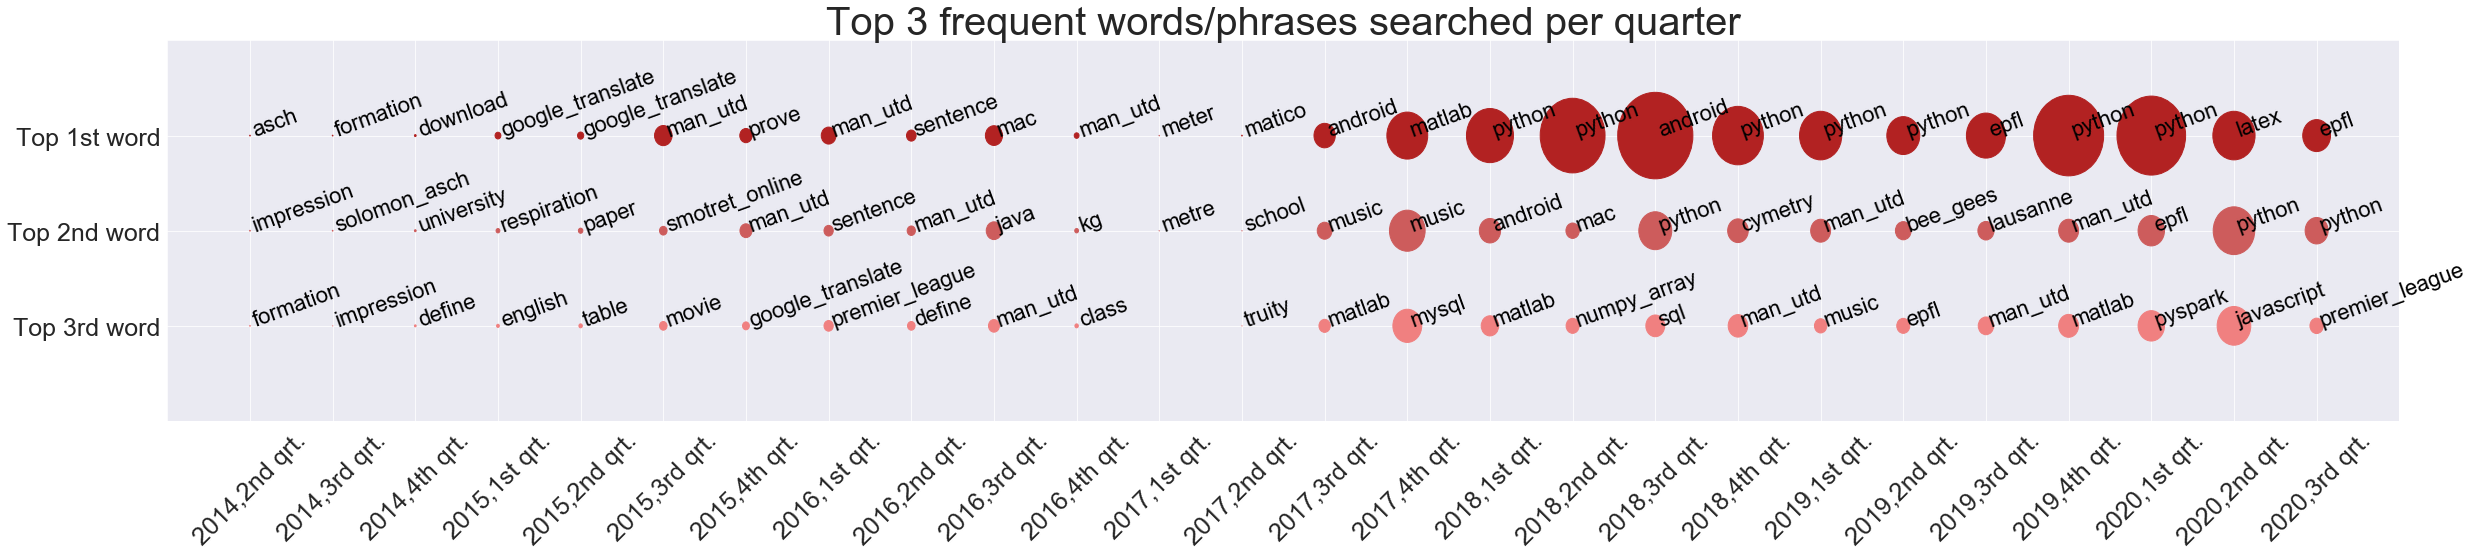

In [21]:
figure, ax = plt.subplots(figsize=(40,7))

ax.set_xlim((0,len(xaxis)+1))
ax.set_ylim((0,4))

colors = ['lightcoral','indianred','firebrick']

for i, e in enumerate(top_words.values()):
    j = 3
    for w in e:
        circle = plt.Circle((i+1,j),w[1]/(2.2*219),color=colors[j-1])
        ax.add_artist(circle)
        ax.text(i + 1, j, w[0], fontsize=22,  color='black',rotation='20')
        j-=1
        
plt.title('Top 3 frequent words/phrases searched per quarter',fontsize=40)    
plt.xticks(list(range(1,len(xaxis_ticks)+1)),xaxis_ticks,rotation='45',fontsize=25);
plt.yticks([1,2,3],['Top 3rd word', 'Top 2nd word', 'Top 1st word'],fontsize=25);